First, train a very simple neural network on the MNIST dataset with only basic PyTorch Tensor functionality. Gradually, add other features *torch.nn, torch.optim, Dataset, DataLoader*.

## MNIST data setup

Using *pathlib* to deal with paths. And downloading the dataset using *requests*.

In [1]:
from pathlib import Path
import requests

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

In [3]:
PATH.mkdir(parents=True, exist_ok=True)

In [4]:
URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

The dataset is in numpy array format and has been stored as pickle, python specific format for serializing data.

In [5]:
import pickle
import gzip

In [6]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28x28 and is stored as a flatenned row of length 784.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(50000, 784)


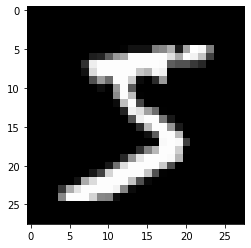

In [8]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
print(x_train.shape)

PyTorch uses torch.tensor rather than numpy arrays. Hence converting them to Tensors

In [9]:
import torch

In [10]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, 
                                        (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape

In [11]:
n, c

(50000, 784)

In [12]:
print(x_train, y_train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])


In [13]:
print(x_train.shape, y_train.shape)

torch.Size([50000, 784]) torch.Size([50000])


In [14]:
print(y_train.min(), y_train.max())

tensor(0) tensor(9)


## Neural Net from Scratch

Fitting a model using only PyTorch tensor operations.

- Initialize weights and bias with zero-filled or random tensors

- They have an extra feature which is *requires_grad*. If it is set to True then PyTorch records all the operations done on tensor so that it can calculate the gradient during backward pass automatically!

- For the weights *required_grad=True* is set after initialization since we don't need that step included in the gradient.

*Note that a trailing _ in PyTorch means the operation is performed in-place.*

> The weights are initialized here with *Xavier initialization* *by multiplying with 1/sqrt(n)).

In [15]:
import math

In [16]:
weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [39]:
weights

tensor([[ 0.0287, -0.0483, -0.0066,  ..., -0.0082, -0.0672,  0.0033],
        [ 0.0548, -0.0596,  0.0348,  ...,  0.0388,  0.0545,  0.0068],
        [-0.0157, -0.0038, -0.0651,  ..., -0.0215, -0.0332,  0.0331],
        ...,
        [-0.0373, -0.0179,  0.0473,  ...,  0.0282, -0.0264, -0.0052],
        [-0.0159, -0.0574, -0.0240,  ...,  0.0457, -0.0034, -0.0221],
        [-0.0682,  0.0339,  0.0028,  ...,  0.0633, -0.0375,  0.0104]],
       requires_grad=True)

In [18]:
# defining log_softmax activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)        # @ : dot product

Calling function only on one batch of data (i.e. 64 images), which is one *forward pass*. So the predictions won't be any better than random at this stage.

In [19]:
bs = 64 # batch size

xb = x_train[0:bs]   # mini-batch
preds = model(xb)

print(preds[0], preds.shape)

tensor([-2.4119, -2.2190, -2.3675, -2.2813, -3.1578, -2.0201, -3.0896, -2.2604,
        -2.2297, -1.7532], grad_fn=<SelectBackward>) torch.Size([64, 10])


As observed, the *preds* tensor not only contains the Tensor values but also a gradient function which can be used for backpropagation.

Defining negative log-likelihood as loss function.

In [20]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Check the loss with our random model. So we can see if it improves after the backpropagation step.

In [21]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3655, grad_fn=<NegBackward>)


Defining a function to calculate accuracy. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [22]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [23]:
print(accuracy(preds, yb))

tensor(0.0938)


Creating a training loop where for each iteration:

- Select a mini-batch of data (of size bs)
- Use the model to make predictions
- Calculate the loss
- loss.backward() updates the gradients of the model, in this case *weights* and *bias*

Now these gradients can be used to update the weights and bias. This is done within *torch.no_grad()* since we do not want these actions to be recorded for the next calculation of the gradient. 

Then the gradients are set to zero for each iteration else it would keep a running tally of all operations that had happened.

In [24]:
bs = 64
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        
        start_i = i * bs
        end_i = start_i + bs
        
        # each batch
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        
        # predict
        pred = model(xb)
        
        # loss
        loss = loss_func(pred, yb)
        
        # backward pass
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

This is an implementation of a minimal neural network (in this case a logistic regression, since there are no hidden layers) entirely from scratch!

In [25]:
# checking loss and accuracy to compare with earlier values
print("Loss: ", loss_func(model(xb), yb))
print("Accuracy: ", accuracy(model(xb), yb))

Loss:  tensor(0.0830, grad_fn=<NegBackward>)
Accuracy:  tensor(1.)


## Using torch.nn functional

Refactoring the code by taking advantage of PyTorch's `nn` classes to make it more concise and flexible.

The first and easiest step is to replace the activation and loss functions with those from `torch.nn.functional` (which is generally imported into the namespace `F` by convention).

If you are using negative log likelihood loss and log softmax activation, then PyTorch provides a single function `F.cross_entropy` that combines the two.

In [26]:
import torch.nn.functional as F

In [27]:
loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [28]:
# checking loss and accuracy to compare with earlier values
print("Loss: ", loss_func(model(xb), yb))
print("Accuracy: ", accuracy(model(xb), yb))

Loss:  tensor(0.0830, grad_fn=<NllLossBackward>)
Accuracy:  tensor(1.)


## Refactor using nn.Module

Next, we will use `nn.Module` and `nn.Parameter` for a more clearer and concise training loop. 

We want to create a class that holds our weights, bias and method for the forward step. We do that by subclassing `nn.Module`.

In [29]:
from torch import nn

In [30]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [31]:
# since now we are using an object instead of a function
# we first need to instantiate our model
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that nn.Module objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.

In [32]:
print(loss_func(model(xb), yb))

tensor(2.4038, grad_fn=<NllLossBackward>)


Previously, in the training loop we had to update the values of each parameter by name as well as manually zero out the grads for each seperately:

```python
with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
```

Now we can take advantage of `model.parameters()` and `model.zero_grad()` to make the steps more concise and less prone to the error of forgetting some of our parameters:

```python
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
    model.zero_grad()
```

In [33]:
# wrap the training loop in a fit function

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            
            start_i = i * bs
            end_i = start_i + bs
            
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            
            # pred
            pred = model(xb)
            # loss
            loss = loss_func(pred, yb)
            
            # backpropagate
            loss.backward()
            
            # update params
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
                
fit()

In [34]:
# double check that loss has gone down
print(loss_func(model(xb), yb))

tensor(0.0810, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear

Instead of manually defining `self.weights`, `self.bias` and calculating `xb @ self.weights + self.bias`, PyTorch's `nn.Linear` class can be used to define a linear layer.

> PyTorch has many predefined layers that can greatly simplify code and often make it faster.

In [35]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [36]:
# instantiate model and calc loss
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3790, grad_fn=<NllLossBackward>)


In [37]:
# now using the fit() method
fit()

print(loss_func(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward>)
